In [1]:
#Librerias

import numpy as np
from keras.preprocessing import image
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.callbacks import *
import keras.preprocessing.image 
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Activation,Flatten,ZeroPadding2D,AveragePooling2D,Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow import keras
from keras import Sequential
from keras.utils import img_to_array,load_img
import glob as gb
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorboard

In [2]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#Definicion de los grupos de edad.
def group_age(group):
    if group == 1 :
        return "0-15"
    if group == 2 :
        return "16-25"
    if group == 3 :
        return "26-40"
    if group == 4 :
        return "41-60"
    else : return "+60"

In [20]:
#Obtención de la gráfica con la distribución por grupo de edad
import os

path = 'edad'

num_arch = {}
for raiz,dirs, arch in os.walk(path):
    if raiz != 'edad':
        num_archivos = len(arch)
        num_arch[raiz] = num_archivos

for sub, num_archivos in num_arch.items():
    print(f'{sub}: {num_archivos} archivos')

edad\1: 6865 archivos
edad\2: 4781 archivos
edad\3: 9836 archivos
edad\4: 5691 archivos
edad\5: 3668 archivos


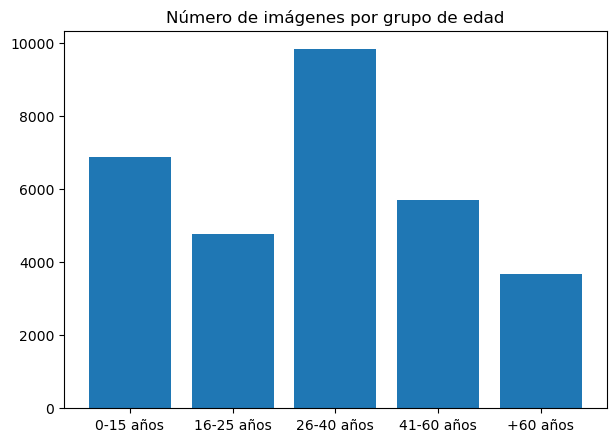

In [25]:
carpetas = list(num_arch.keys())
numeros_archivos = list(num_arch.values())
test = ['0-15 años','16-25 años','26-40 años','41-60 años','+60 años']

frequency, bins = np.histogram(numeros_archivos, bins=10)
fig, axes = plt.subplots(figsize=(7,5), dpi=100)
plt.bar(test,numeros_archivos)
plt.title('Número de imágenes por grupo de edad')


In [5]:
#Carga del dataset con un 10% en validación, la parte del test ya está dividida en otra carpeta.
nbatch = 32

data_with_aug = ImageDataGenerator(horizontal_flip=True,rotation_range=10,width_shift_range=0.1,height_shift_range=0.1,vertical_flip=False,rescale = 1./255,validation_split=0.10)

training_set = data_with_aug.flow_from_directory('edad/',
                                                 target_size=(200,200),
                                                 batch_size =nbatch,
                                                 class_mode = 'categorical',subset='training')

val = data_with_aug.flow_from_directory('edad/',
                                        target_size=(200,200),
                                        batch_size =nbatch,
                                        class_mode = 'categorical',subset='validation')
                                        
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory('edadtest/',
                                               class_mode="categorical",
                                               target_size=(200,200),
                                               batch_size=nbatch,
                                               shuffle=False)



Found 27759 images belonging to 5 classes.
Found 3082 images belonging to 5 classes.
Found 2644 images belonging to 5 classes.


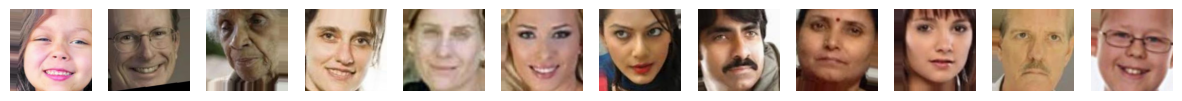

In [40]:
#Ejemplos de imágenes de entrada
fig, ax = plt.subplots(nrows=1, ncols=12, figsize=(15,15))

for i in range(12):
    image = next(training_set)[0]
    image = np.squeeze(image)

    ax[i].imshow(image)
    ax[i].axis('off')

In [2]:
#Primer modelo, red convolucional 
model1 = Sequential()

model1.add(Conv2D(filters =32, kernel_size = (5,5), padding = "Same", activation = "relu", input_shape = (200,200,3)))
model1.add(Conv2D(64,(3,3),activation="relu"))
model1.add(AveragePooling2D(2,2))

model1.add(Conv2D(128,(3,3),activation="relu"))
model1.add(AveragePooling2D(2,2))

model1.add(Conv2D(256,(3,3),activation="relu"))
model1.add(AveragePooling2D(2,2))

model1.add(Conv2D(512,(3,3),activation="relu"))
model1.add(GlobalAveragePooling2D())

model1.add(Dense(512))
model1.add(Activation("relu"))
model1.add(Dropout(0.25))
model1.add(Dense(5))
model1.add(Activation("softmax"))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 198, 198, 64)      18496     
                                                                 
 average_pooling2d (AverageP  (None, 99, 99, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 97, 97, 128)       73856     
                                                                 
 average_pooling2d_1 (Averag  (None, 48, 48, 128)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 46, 46, 256)       2

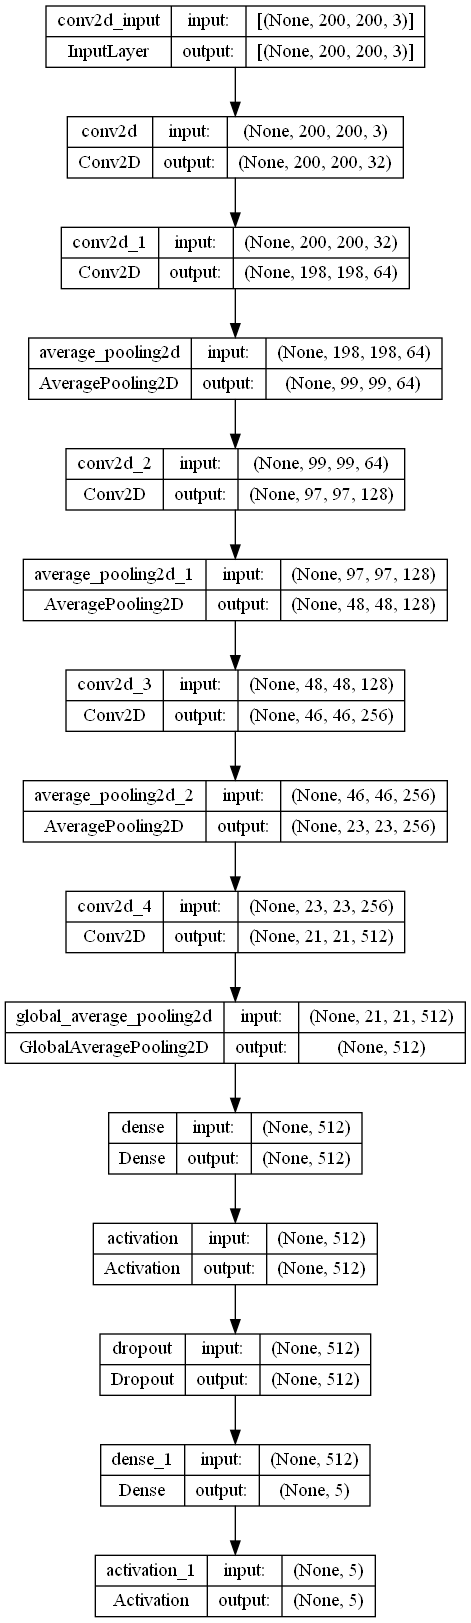

In [4]:
#Grafico del modelo
tf.keras.utils.plot_model(model1, to_file='convAgeModel.png', show_shapes=True)

In [118]:
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics="CategoricalAccuracy")

In [2]:
#Learning rate que decrece a partir de la epoca 20
def scheduler(epoch, lr):
    if epoch < 20:
        return 0.001
    else:
        return lr * tf.math.exp(-0.1)

In [120]:
#Entrenamiento
lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)
checkpoint_filepath = 'modelos/clasificadoresEdad/model1.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)
hist =  model1.fit(training_set,
                    epochs=60,
                    callbacks=[lr_callbacks,model_checkpoint_callback],
                    validation_data=val)

Epoch 1/60
868/868 [==============================] - 145s 167ms/step - loss: 1.4852 - categorical_accuracy: 0.3733 - val_loss: 1.4763 - val_categorical_accuracy: 0.3861 - lr: 0.0010
Epoch 2/60
868/868 [==============================] - 140s 161ms/step - loss: 1.3800 - categorical_accuracy: 0.4217 - val_loss: 1.4199 - val_categorical_accuracy: 0.4182 - lr: 0.0010
Epoch 3/60
868/868 [==============================] - 140s 161ms/step - loss: 1.2407 - categorical_accuracy: 0.4805 - val_loss: 1.2977 - val_categorical_accuracy: 0.4883 - lr: 0.0010
Epoch 4/60
868/868 [==============================] - 139s 160ms/step - loss: 1.1019 - categorical_accuracy: 0.5315 - val_loss: 1.1456 - val_categorical_accuracy: 0.5480 - lr: 0.0010
Epoch 5/60
868/868 [==============================] - 133s 153ms/step - loss: 0.9779 - categorical_accuracy: 0.5828 - val_loss: 1.1617 - val_categorical_accuracy: 0.5373 - lr: 0.0010
Epoch 6/60
868/868 [==============================] - 131s 151ms/step - loss: 0.9249 

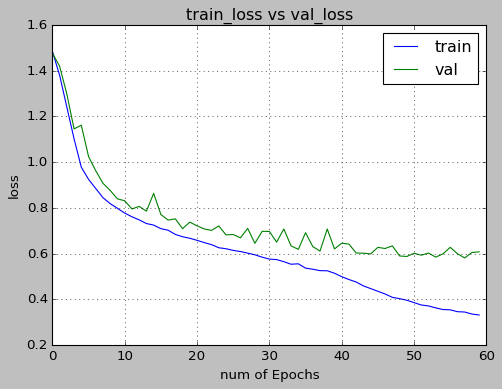

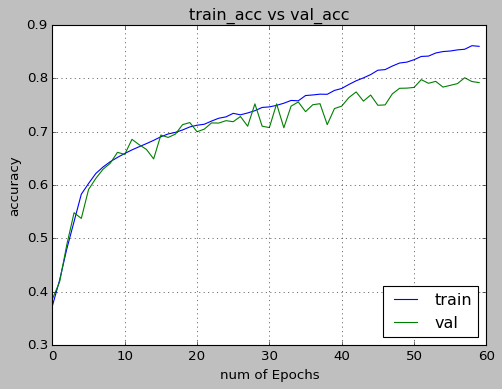

In [122]:
#Gráfica de entrenamiento del modelo convolucional
epochs = 60
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['categorical_accuracy']
val_acc = hist.history['val_categorical_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

In [123]:
model1.load_weights('modelos/clasificadoresEdad/model1.h5')

In [124]:
Y_pred = model1.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)


83/83 [==============================] - 3s 33ms/step


In [125]:
#Evaluación de la red neuronal
from sklearn.metrics import classification_report
groups = ['0-15','16-25','26-40','41-60','+60']
print(classification_report(test_set.classes,y_pred,target_names=groups))

              precision    recall  f1-score   support

        0-15       0.96      0.95      0.96       573
       16-25       0.69      0.60      0.64       399
       26-40       0.71      0.79      0.75       820
       41-60       0.70      0.71      0.70       518
         +60       0.86      0.75      0.80       334

    accuracy                           0.78      2644
   macro avg       0.78      0.76      0.77      2644
weighted avg       0.78      0.78      0.78      2644



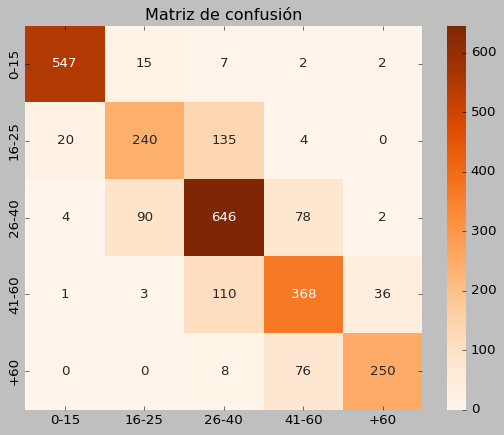

In [126]:
#Matriz de confusion
cf_matrix = confusion_matrix(test_set.classes, y_pred)
groups = ['0-15','16-25','26-40','41-60','+60']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

sns.heatmap(cf_matrix,annot=True,cmap='Oranges',fmt='.0f',xticklabels=groups,yticklabels=groups)
plt.title('Matriz de confusión')
plt.show()

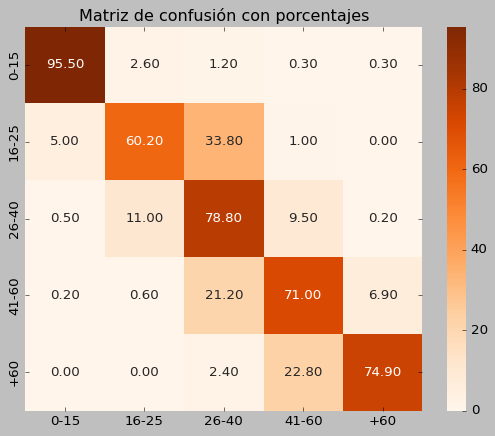

In [127]:
#Matriz de confusion con porcentajes
total_por_clase = np.sum(cf_matrix, axis=1)
porcentaje_por_clase = np.round(cf_matrix / total_por_clase[:, None] * 100, 1)

sns.heatmap(porcentaje_por_clase,cmap='Oranges', annot=True, fmt='.2f', xticklabels=groups, yticklabels=groups)

plt.title('Matriz de confusión con porcentajes')
plt.show()


In [15]:
#Modelo con VGG16 y transferlearning mediante la red preentrenada con ImageNet
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(200,200,3))
vgg16_model.summary()


model = Sequential([vgg16_model,Flatten(),Dense(128,activation='relu'),Dense(32,activation='relu'),Dense(5,activation= "softmax")])
model.layers[0].trainable = False
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics="CategoricalAccuracy")
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [16]:
#Entrenamiento de la red VGG con Transfer Learning
lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)
checkpoint_filepath = 'modelos/clasificadoresEdad/vgg16_improve'
tensorboard = TensorBoard(log_dir="tensorboard/vgg_transfer")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)
hist =  model.fit(training_set,
                    epochs=50,
                    callbacks=[lr_callbacks,model_checkpoint_callback,tensorboard],
                    validation_data=val,
                    steps_per_epoch=500)

Epoch 1/50
500/500 [==============================] - 91s 182ms/step - loss: 1.0216 - categorical_accuracy: 0.5716 - val_loss: 0.9547 - val_categorical_accuracy: 0.6243 - lr: 0.0010
Epoch 2/50
500/500 [==============================] - 90s 179ms/step - loss: 0.8699 - categorical_accuracy: 0.6220 - val_loss: 0.9595 - val_categorical_accuracy: 0.6084 - lr: 0.0010
Epoch 3/50
500/500 [==============================] - 90s 180ms/step - loss: 0.8353 - categorical_accuracy: 0.6372 - val_loss: 0.8761 - val_categorical_accuracy: 0.6437 - lr: 0.0010
Epoch 4/50
500/500 [==============================] - 89s 177ms/step - loss: 0.8181 - categorical_accuracy: 0.6462 - val_loss: 0.8594 - val_categorical_accuracy: 0.6535 - lr: 0.0010
Epoch 5/50
500/500 [==============================] - 87s 174ms/step - loss: 0.7963 - categorical_accuracy: 0.6553 - val_loss: 0.8906 - val_categorical_accuracy: 0.6496 - lr: 0.0010
Epoch 6/50
500/500 [==============================] - 89s 177ms/step - loss: 0.7862 - cate

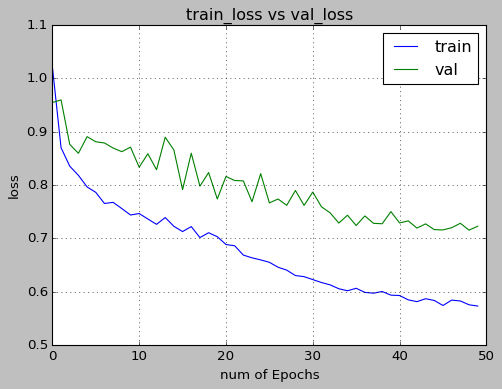

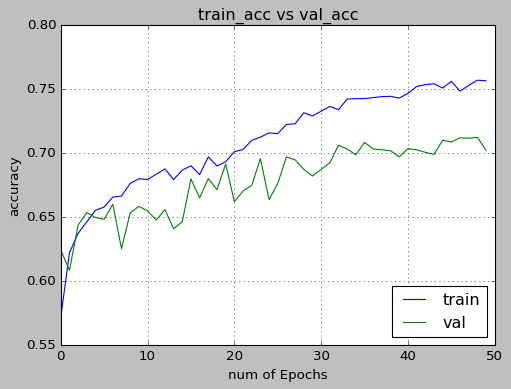

In [18]:
#Grafica de entrenamiento de la red VGG con Transfer Learning
epochs = 50
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['categorical_accuracy']
val_acc = hist.history['val_categorical_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

In [11]:
model.load_weights('modelos/clasificadoresEdad/vgg16_improve')

In [19]:
#Resultados de la red VGG_16 y transfer learning

Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_set.classes,y_pred,target_names=groups))

83/83 [==============================] - 5s 57ms/step
              precision    recall  f1-score   support

        0-15       0.96      0.92      0.94       573
       16-25       0.58      0.48      0.53       399
       26-40       0.64      0.74      0.68       820
       41-60       0.63      0.63      0.63       518
         +60       0.80      0.72      0.76       334

    accuracy                           0.71      2644
   macro avg       0.72      0.70      0.71      2644
weighted avg       0.72      0.71      0.71      2644



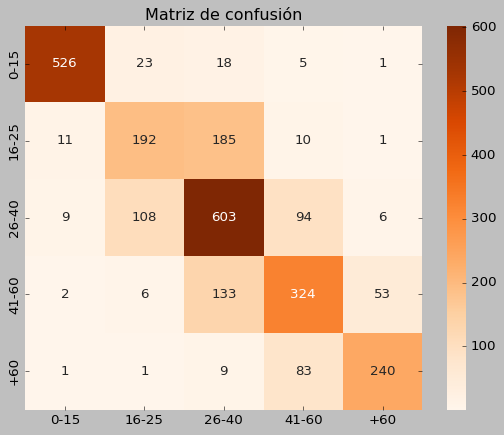

In [23]:
#Matriz de confusion de la red VGG con Transfer Learning

cf_matrix = confusion_matrix(test_set.classes, y_pred)
groups = ['0-15','16-25','26-40','41-60','+60']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

sns.heatmap(cf_matrix,annot=True,cmap='Oranges',fmt='.0f',xticklabels=groups,yticklabels=groups)
plt.title('Matriz de confusión')
plt.show()

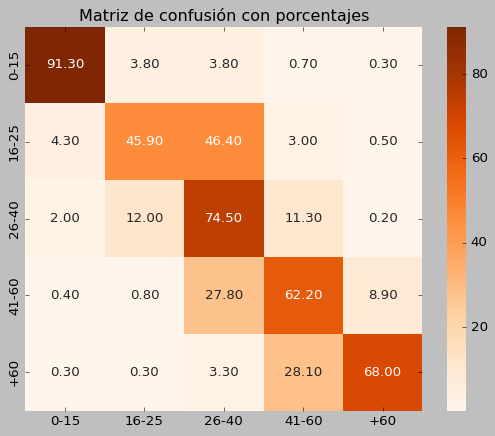

In [22]:
#Matriz de confusion con porcentajes de la red VGG con Transfer Learning
total_por_clase = np.sum(cf_matrix, axis=1)
porcentaje_por_clase = np.round(cf_matrix / total_por_clase[:, None] * 100, 1)

sns.heatmap(porcentaje_por_clase,cmap='Oranges', annot=True, fmt='.2f', xticklabels=groups, yticklabels=groups)

plt.title('Matriz de confusión con porcentajes')
plt.show()


In [ ]:
#Red MobileNet

In [108]:
from keras.applications.mobilenet import MobileNet
from keras.layers import BatchNormalization,GlobalAveragePooling2D

mobilenet = MobileNet(input_shape= (200,200,3),include_top= False,weights=None)

model3 = Sequential()
model3.add(mobilenet)
model3.add(GlobalAveragePooling2D())
model3.add(Dropout(0.25)) #Capa Dropout y adaptación de la salida.
model3.add(Dense(5,activation='softmax'))

model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [109]:
model3.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_200 (Functio  (None, 6, 6, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_18 (Dropout)        (None, 1024)              0         
                                                                 
 dense_37 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 3,233,989
Trainable params: 3,212,101
Non-trainable params: 21,888
_________________________________________________________________


In [110]:
#Entrenamiento de MobileNet
lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)
tensorboard = TensorBoard(log_dir="tensorboard/mobilenet")
checkpoint_filepath = 'modelos/clasificadoresEdad/mobilenet.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
hist =  model3.fit(training_set,
                    epochs=55,
                    callbacks=[lr_callbacks,model_checkpoint_callback,tensorboard],
                    validation_data=test_set,   
                    steps_per_epoch=400)

Epoch 1/55
400/400 [==============================] - 70s 169ms/step - loss: 1.3851 - accuracy: 0.4155 - val_loss: 2.1289 - val_accuracy: 0.3101 - lr: 0.0010
Epoch 2/55
400/400 [==============================] - 63s 157ms/step - loss: 1.1309 - accuracy: 0.5088 - val_loss: 1.2182 - val_accuracy: 0.5068 - lr: 0.0010
Epoch 3/55
400/400 [==============================] - 61s 152ms/step - loss: 1.0260 - accuracy: 0.5604 - val_loss: 1.1491 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 4/55
400/400 [==============================] - 62s 154ms/step - loss: 0.9748 - accuracy: 0.5808 - val_loss: 1.1436 - val_accuracy: 0.5208 - lr: 0.0010
Epoch 5/55
400/400 [==============================] - 59s 148ms/step - loss: 0.9325 - accuracy: 0.5934 - val_loss: 0.9922 - val_accuracy: 0.5790 - lr: 0.0010
Epoch 6/55
400/400 [==============================] - 60s 151ms/step - loss: 0.9046 - accuracy: 0.6097 - val_loss: 1.1879 - val_accuracy: 0.5363 - lr: 0.0010
Epoch 7/55
400/400 [==============================] 

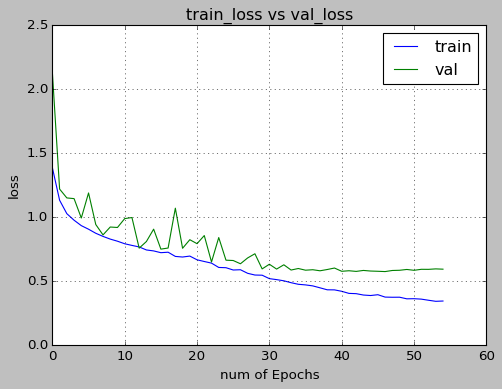

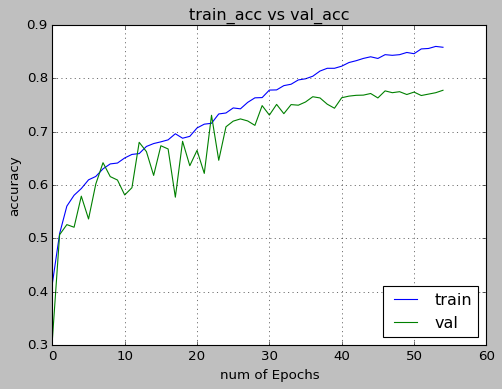

In [111]:
#Gráfica del entrenamiento de la red mobilenet
epochs = 55
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

In [112]:
model3.load_weights('modelos/clasificadoresEdad/mobilenet.h5')

In [113]:
Y_pred = model3.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)

cf_matrix = confusion_matrix(test_set.classes, y_pred)
cf_matrix

83/83 [==============================] - 3s 31ms/step


array([[551,  21,   1,   0,   0],
       [ 15, 251, 127,   6,   0],
       [  3, 109, 626,  78,   4],
       [  0,   4, 105, 362,  47],
       [  0,   0,   3,  65, 266]], dtype=int64)

In [114]:
#Resultados red MobileNet
print(classification_report(test_set.classes,y_pred,target_names=groups))

              precision    recall  f1-score   support

        0-15       0.97      0.96      0.96       573
       16-25       0.65      0.63      0.64       399
       26-40       0.73      0.76      0.74       820
       41-60       0.71      0.70      0.70       518
         +60       0.84      0.80      0.82       334

    accuracy                           0.78      2644
   macro avg       0.78      0.77      0.77      2644
weighted avg       0.78      0.78      0.78      2644



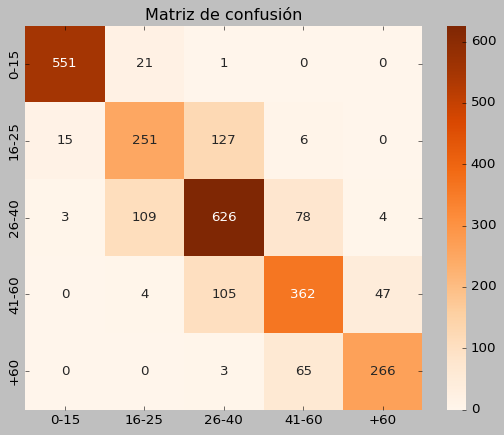

In [115]:
#Matriz de confusion red MobileNet
cf_matrix = confusion_matrix(test_set.classes, y_pred)
groups = ['0-15','16-25','26-40','41-60','+60']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

sns.heatmap(cf_matrix,annot=True,cmap='Oranges',fmt='.0f',xticklabels=groups,yticklabels=groups)
plt.title('Matriz de confusión')
plt.show()

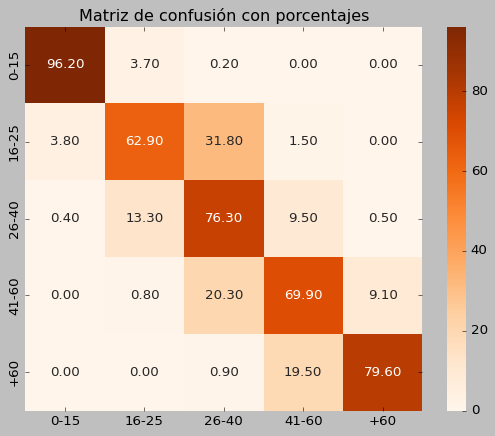

In [116]:
#Matriz de confusion con porcentajes de la red MobileNet
total_por_clase = np.sum(cf_matrix, axis=1)
porcentaje_por_clase = np.round(cf_matrix / total_por_clase[:, None] * 100, 1)

sns.heatmap(porcentaje_por_clase,cmap='Oranges', annot=True, fmt='.2f', xticklabels=groups, yticklabels=groups)

plt.title('Matriz de confusión con porcentajes')
plt.show()
